In [1]:
import numpy as np
import umap
from fbpca import pca
from ipywidgets import interact, interact_manual
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import csv
import pandas as pd
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from heapq import nlargest
from scipy.stats import spearmanr
from sklearn.decomposition import FastICA

In [2]:
import warnings
import os
warnings.simplefilter('ignore')

os.chdir('/Users/bdemeo/Documents/bergerlab/lsh/ample/bin')
from datatools import *
from dataset import *

os.chdir('/Users/bdemeo/Documents/bergerlab/lsh/ample')

In [3]:
import csv
import os
from sklearn import preprocessing

def open_data(NAMESPACE, parent_dir='data/', delimiter = '\t', dimred=True, annos = []):

    filename = 'dimred' if dimred else 'full'
    with open(parent_dir+NAMESPACE+'/'+filename+'.txt') as f:
        reader = csv.reader(f, delimiter = delimiter)
        data = np.array(list(reader)).astype(float) #assumes clean data, no column names

    result = dataset(data, path=parent_dir+NAMESPACE+'/')


    for anno in annos: #search for the indicated annotation file
        if os.path.exists(parent_dir+NAMESPACE+'/'+anno+'.txt'):
            with open(parent_dir+NAMESPACE+'/'+anno+'.txt') as f:
                reader = csv.reader(f, delimiter = delimiter)
                labels = np.array(list(reader))
                labels = [x[0] for x in labels]
                result.data[anno] = labels
        else:
            print('WARNING: could not find annotation {}'.format(anno))


    #search for subsamples
    if os.path.exists(parent_dir+NAMESPACE+'/ft.txt'):
        result.load_subsample(parent_dir+NAMESPACE+'/ft.txt', name='ft', delimiter=delimiter)


    return(result)


In [4]:
def top_diffs(k=1):
    def F(x,y):
        diffs = np.absolute(np.array(x)-np.array(y))
        #print(diffs)
        topdiffs = nlargest(k, diffs)
        return(np.linalg.norm(topdiffs))
    return(F)
    

In [5]:
def spearman(x,y):
    return 1/spearmanr(np.array(x),np.array(y)).correlation

In [6]:
def trunc_euclidean(k=5):
    def F(x,y):
        return np.linalg.norm(np.array(x)[:k]-np.array(y)[:k])
    
    return(F)
    

In [7]:
def knn_density(data, k=5, metric='euclidean'):
    """Produces a crude density estimate at each point"""
    nbrs = NearestNeighbors(n_neighbors=k, metric=metric).fit(data)
    distances, indices = nbrs.kneighbors(data)
    
    print(distances)
    result = [dists[k-1] for dists in distances]
    return(result)
    

In [8]:
def adjusted_euclidean(data, k=5):
    nbr_dists = knn_density(data, k)
    scalings = np.sqrt(np.matmul(np.transpose(nbr_dists),nbr_dists))
    return(np.divide(pairwise_distances(data), scalings))

In [11]:
pbmc = open_data('pbmc',annos=['labels'])
pbmc = pbmc.subsamples['ft']

In [15]:
reducer = FastICA(n_components=20)

In [16]:
reduced = reducer.fit_transform(pbmc.rawdata())

In [18]:
pbmc_ic = dataset(reduced)

In [ ]:
pbmc_ic.heatmap() 

computing distances...


In [ ]:
pbmc_ic.make_subsampler('FTSampler_exact')

In [69]:
dendritic = pbmc.subset('labels','Dendritic')

In [71]:
dendritic.grow()

making embedding
making embedding
embedding size 199
(199, 3)


aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0xMDAsIGRlc2NyaXB0aW9uPXUnTicsIG1heD0xOTksIG1pbj0xKSwgRHJvcGRvd24oZGVzY3JpcHRpb249dSdjb2xvcicsIG/igKY=


In [72]:
np.unique(pbmc.data['labels'])

array(['CD14+_Monocyte', 'CD19+_B', 'CD4+/CD25_T_Reg',
       'CD4+/CD45RA+/CD25-_Naive_T', 'CD4+/CD45RO+_Memory',
       'CD4+_T_Helper2', 'CD56+_NK', 'CD8+/CD45RA+_Naive_Cytotoxic',
       'CD8+_Cytotoxic_T', 'Dendritic'], dtype=object)

In [73]:
@interact
def view_subpop(pop = list(np.unique(pbmc.data['labels']))):
    pbmc.subset('labels',pop).grow()

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUncG9wJywgb3B0aW9ucz0oJ0NEMTQrX01vbm9jeXRlJywgJ0NEMTkrX0InLCAnQ0Q0Ky9DRDI1X1RfUmVnJywgJ0PigKY=


In [47]:
pbmc = pbmc[:1000]
pbmc.sort_values('labels')
pbmc_raw = pbmc.data.values[:,:pbmc.numFeatures]

[[0.         0.50547428 0.51208577 0.51595282 0.51889229]
 [0.         0.50340908 0.50409619 0.51034222 0.51157592]
 [0.         0.50381543 0.51184443 0.51270722 0.53551378]
 ...
 [0.         0.52360415 0.56483091 0.66735796 0.80242552]
 [0.         0.52360415 0.602257   0.66625451 0.71591897]
 [0.         0.52790174 0.56623372 0.5688608  0.57068282]]


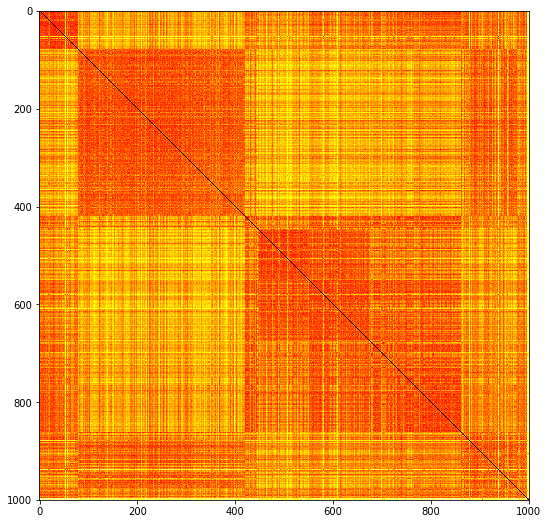

In [52]:
plt.imshow(adjusted_euclidean(pbmc_raw), cmap='hot')

In [63]:
densities = knn_density(pbmc_raw,k=2, metric=trunc_euclidean(2))
densities

[[0.         0.01490191]
 [0.         0.00527171]
 [0.         0.0216166 ]
 ...
 [0.         0.09509668]
 [0.         0.02350704]
 [0.         0.00794592]]


[0.014901908480964178,
 0.00527170981570873,
 0.021616598024003234,
 0.009185272239400761,
 0.006990227959632455,
 0.0057370702623125835,
 0.0104367983883556,
 0.011789989192402617,
 0.010845296148687171,
 0.011510970231756148,
 0.007000588918917286,
 0.008112906003512403,
 0.011048545993589927,
 0.010571439731900783,
 0.005281664337303071,
 0.010847700102519318,
 0.011624078196673897,
 0.008348229740796872,
 0.012184074354395969,
 0.00457245310077722,
 0.006975434209522697,
 0.010962561668166431,
 0.005264386329970055,
 0.007573931057465609,
 0.011924709138372085,
 0.014708830413462243,
 0.009392152700854431,
 0.0220808534475627,
 0.04941476942384624,
 0.010157125233743779,
 0.015104957823113925,
 0.005369941083714426,
 0.011607019051531373,
 0.0006590099240122564,
 0.022408303218854668,
 0.01107376966346825,
 0.014901908480964178,
 0.019263443770661873,
 0.012747807977129556,
 0.010600073371910065,
 0.006995074667223798,
 0.013547154987554422,
 0.010593293955611503,
 0.01355402344105

computing distances...


array([[0.        , 0.56932214, 0.73213904, ..., 1.1763439 , 1.20850936,
        0.85888593],
       [0.56932214, 0.        , 0.61985425, ..., 1.15811686, 1.17930818,
        0.75356935],
       [0.73213904, 0.61985425, 0.        , ..., 1.06663783, 1.03113596,
        0.61905248],
       ...,
       [1.1763439 , 1.15811686, 1.06663783, ..., 0.        , 0.52360415,
        0.80242552],
       [1.20850936, 1.17930818, 1.03113596, ..., 0.52360415, 0.        ,
        0.77817044],
       [0.85888593, 0.75356935, 0.61905248, ..., 0.80242552, 0.77817044,
        0.        ]])

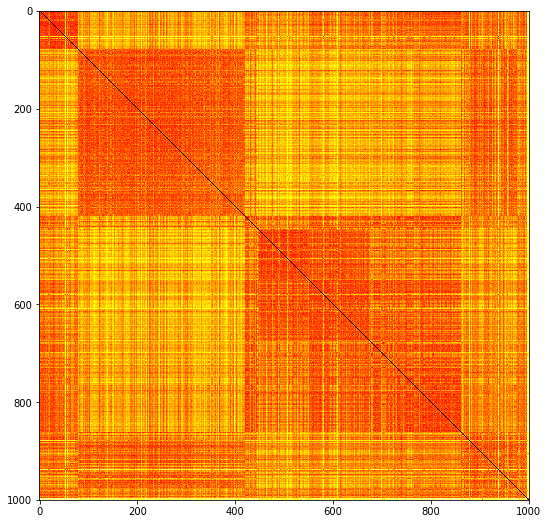

In [51]:
pbmc.heatmap()

computing distances...


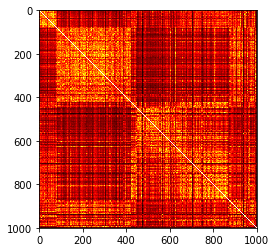

In [23]:
pbmc.heatmap(top_diffs(10))

In [1]:
pbmc.heatmap(trunc_euclidean(10))

NameError: name 'pbmc' is not defined